In [1]:
import os
from sys import exit
import numpy as np
import time
import matplotlib.pyplot as plt
import keras, tensorflow as tf
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, ReLU, Dense, Flatten, Reshape , Conv2D , MaxPooling2D
from keras.layers import Dropout, BatchNormalization

### Введем данные взятые с сайта Kaggle


In [2]:
data_path = '/Users/Alexander/Desktop/Курсач ПИ/dataset/'
model_path = '/Users/Alexander/Desktop/Курсач ПИ/' + 'model.pt'

### Для более быстрого тоступа к датасету создадим короткие переменные , хранящие в себе путь к файлам

In [3]:
train_path = (data_path + 'train/')
val_path = (data_path + 'val/')

In [4]:
cat_train = (train_path + 'cat/')
dog_train = (train_path + 'dog/')
wild_train = (train_path + 'wild/')

cat_val = (val_path + 'cat/')
dog_val = (val_path + 'dog/')
wild_val = (val_path + 'wild/')

## Выведем количество параметров у входных данных

In [5]:
num_cat_train = len(os.listdir(cat_train))
num_dog_train = len(os.listdir(dog_train))
num_wild_train = len(os.listdir(wild_train))

num_cat_val = len(os.listdir(cat_val))
num_dog_val = len(os.listdir(dog_val))
num_wild_val = len(os.listdir(wild_val))

num_all_train = num_cat_train + num_dog_train + num_wild_train
num_all_val = num_cat_val + num_dog_val + num_wild_val

In [6]:
print("###############################################################################\n")
print("Количество тренировочных изображений котов = " , num_cat_train)
print("Количество тренировочных изображений собак = " , num_dog_train)
print("Количество тренировочных изображений диких животных = " , num_wild_train)
print("\n################################################################################\n")
print("Количество валидационных изображений котов = " , num_cat_val)
print("Количество валидационных изображений собак = " , num_dog_val)
print("Количество валидационных изображений диких животных = " , num_wild_val)
print("\n################################################################################\n")
print("Общее количество тренировочных параметров = " , num_all_train)
print("Общее количество валидационных праметров = " , num_all_val)
print("\n################################################################################")

###############################################################################

Количество тренировочных изображений котов =  5153
Количество тренировочных изображений собак =  4739
Количество тренировочных изображений диких животных =  4738

################################################################################

Количество валидационных изображений котов =  500
Количество валидационных изображений собак =  500
Количество валидационных изображений диких животных =  500

################################################################################

Общее количество тренировочных параметров =  14630
Общее количество валидационных праметров =  1500

################################################################################


## Формат изображений 

В датасете все фотографии уже приведены к единому размеру , а большое количество изображений
поможет нам избежать переобучения модели и достичь точности в >90%

In [7]:
img_shape = 150 # Такой же размер и у изображений в датасете

batch = 100

Создадим функцию которая будет рисовать нам наши изображения

In [8]:
def plotImg(image):
    fig, axs = plt.subplots(1, 5, figsize=(20,20))
    axs = axs.flatten()
    for img, ax in zip(image, axs):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()   

## Создадим наборы изображений 

Тренировочный набор

In [9]:
image_generate = ImageDataGenerator(rescale=1./255)

train_data = image_generate.flow_from_directory(
    batch_size = batch,
    directory = train_path,
    shuffle = True,
    target_size = (img_shape , img_shape)
                                                )

Found 14630 images belonging to 3 classes.


Не забываем сравнить контрольные суммы изображений

In [10]:
image_generate = ImageDataGenerator(rescale=1./255)

val_data = image_generate.flow_from_directory(
    batch_size = batch,
    directory = val_path,
    shuffle = False,
    target_size = (img_shape , img_shape)
                                                )

Found 1500 images belonging to 3 classes.


Аналогично поступаем и здесь

##### Теперь выведем изображения в случайном порядке

In [11]:
sample_trainImg, _ = next(train_data)
sample_valImg , _ = next(val_data)

Тренировочные изображения:

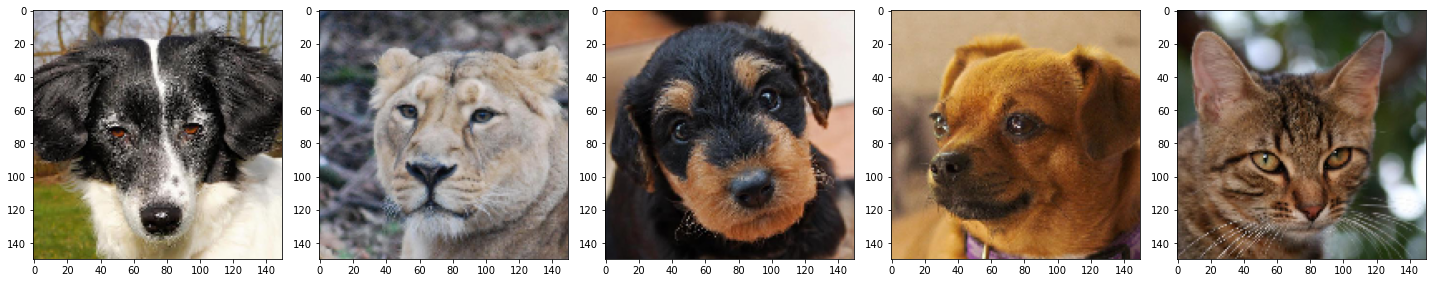

In [12]:
plotImg(sample_trainImg[:5])

Валидационные изображения:

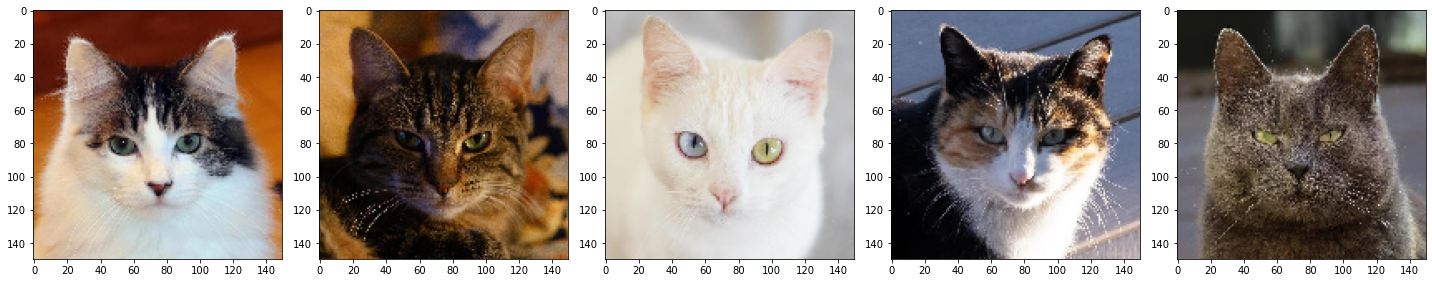

In [13]:
plotImg(sample_valImg[:5])

## Далее создадим модель , используя Keras

In [14]:
input_shape = (img_shape, img_shape , 3)

inp = Input(shape = input_shape) 
x = inp
x = Conv2D(32 , (5,5) , padding='same' , activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2) , strides=2)(x)
x = Conv2D(64 , (5,5) , padding='same' , activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2) , strides=2)(x)
x = Flatten()(x)
x = Dense(units = 256, activation = 'relu')(x)
x = Dropout(rate=0.2)(x) 
x = Dense(units = 32, activation = 'relu')(x)

output = Dense(3, activation = 'softmax')(x)
model = Model(inputs = inp, outputs = output)

Соберем модель и рассмотрим её

In [15]:
model.compile(optimizer = 'Adam',
              loss = 'mse', 
              metrics = ['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 87616)             0     

In [17]:
EPOCHS = 20
history = model.fit(
    train_data,
    steps_per_epoch=int(np.ceil(num_all_train / float(batch))),
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=int(np.ceil(num_all_val / float(batch)))
)

Epoch 1/20
147/147 [==============================] - 387s 3s/step - loss: 0.1332 - accuracy: 0.7301 - val_loss: 0.0514 - val_accuracy: 0.9027
Epoch 2/20
147/147 [==============================] - 378s 3s/step - loss: 0.0361 - accuracy: 0.9308 - val_loss: 0.0387 - val_accuracy: 0.9233
Epoch 3/20
147/147 [==============================] - 387s 3s/step - loss: 0.0221 - accuracy: 0.9563 - val_loss: 0.0362 - val_accuracy: 0.9287
Epoch 4/20
147/147 [==============================] - 384s 3s/step - loss: 0.0125 - accuracy: 0.9766 - val_loss: 0.0307 - val_accuracy: 0.9473
Epoch 5/20
147/147 [==============================] - 386s 3s/step - loss: 0.0089 - accuracy: 0.9833 - val_loss: 0.0275 - val_accuracy: 0.9453
Epoch 6/20
147/147 [==============================] - 385s 3s/step - loss: 0.0062 - accuracy: 0.9888 - val_loss: 0.0235 - val_accuracy: 0.9540
Epoch 7/20
147/147 [==============================] - 386s 3s/step - loss: 0.0061 - accuracy: 0.9889 - val_loss: 0.0423 - val_accuracy: 0.9147

In [18]:
print('Модель сохранена в файле', model_path)
model.save(model_path)
history = history.history

Модель сохранена в файле /Users/Alexander/Desktop/Курсач ПИ/model.pt
INFO:tensorflow:Assets written to: /Users/Alexander/Desktop/Курсач ПИ/model.pt\assets


In [19]:
with open('/Users/Alexander/Desktop/Курсач ПИ/fn_loss.txt', 'w') as output:
    for val in history['loss']: output.write(str(val) + '\n')
with open('/Users/Alexander/Desktop/Курсач ПИ/fn_acc.txt', 'w') as output:
    for val in history['accuracy']: output.write(str(val) + '\n')
with open('/Users/Alexander/Desktop/Курсач ПИ/fn_val_loss.txt', 'w') as output:
    for val in history['val_loss']: output.write(str(val) + '\n')
with open('/Users/Alexander/Desktop/Курсач ПИ/fn_val_acc.txt', 'w') as output:
    for val in history['val_accuracy']: output.write(str(val) + '\n')

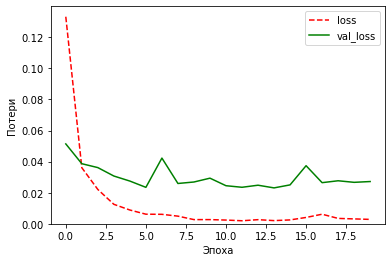

In [42]:
def one_plot(n, y_lb, loss_acc, val_loss_acc):
    plt.subplot(1, 2, n)
    if n == 1:
        lb, lb2 = 'loss', 'val_loss'
        yMin = 0
        yMax = 1.05 * max(max(loss_acc), max(val_loss_acc))
    else:
        lb, lb2 = 'acc', 'val_acc'
        yMin = min(min(loss_acc), min(val_loss_acc))
        yMax = 1.0
    plt.plot(loss_acc, color = 'r', label = lb, linestyle = '--')
    plt.plot(val_loss_acc, color = 'g', label = lb2)
    plt.ylabel(y_lb)
    plt.xlabel('Эпоха')
    plt.ylim([0.95 * yMin, yMax])
    plt.legend()

plt.figure(figsize=(15, 4))
plt.subplots_adjust(wspace=0.5)
one_plot(1, 'Потери', history['loss'], history['val_loss'])
plt.savefig('loss.png')


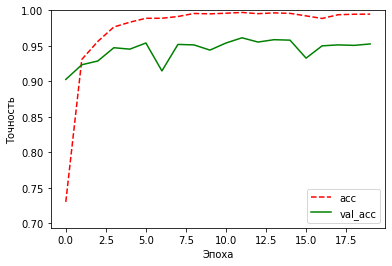

In [43]:
plt.figure(figsize=(15, 4))
plt.subplots_adjust(wspace=0.5)
one_plot(2, 'Точность', history['accuracy'], history['val_accuracy'])
plt.savefig('acc.png')